In [126]:
import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona
from geopy import distance

from numba import jit

from pysheds.grid import Grid
from shapely.geometry import shape, mapping, Polygon

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3
from bokeh.layouts import gridplot

import matplotlib.pyplot as plt
import matplotlib.patches as mp

from get_station_data import get_daily_runoff
from radar_station_coords import radar_sites

output_notebook()
%matplotlib inline

Loading BokehJS ...

In [58]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')
FP_DIR = os.path.join(DB_DIR, 'na_dem_15s_grid')
GDIR_DIR = os.path.join(DB_DIR, 'na_dir_15s_grid')

In [5]:
results_folders = os.listdir(RESULTS_DIR)

results_dict = {}
# create a dictionary of results from all AD searches
for f in results_folders:
    folder_path = os.path.join(RESULTS_DIR, f)
    all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
    for site in all_sites:
        if site in results_dict.keys():
            old_results = results_dict[site]
            new_results = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))
            results_dict[site] = pd.concat([old_results, new_results], sort=True)
        else:            
            results_dict[site] = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))


def get_best_result(site):
    ad_df = pd.DataFrame(results_dict[site])
    ad_df.drop(labels='Unnamed: 0', inplace=True, axis=1)
    ad_df.sort_values('len_results', inplace=True, ascending=False)
    return ad_df.iloc[0, :]

In [6]:
def find_closest_radar_stn(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[0]


def find_closest_radar_stn_distance(row):
    """ 
    Input the dict of all station distances,
    Return the location code of the nearest radar station.
    """
    radar_station_distances = row['radar_stn_distance_dict']
    min_dist = min(radar_station_distances.items(), key=lambda x: x[1])
    return min_dist[1]


def calc_distance(wsc_row, station):
    wsc_stn_coords = (wsc_row['Latitude'], wsc_row['Longitude'])
    radar_coords = radar_sites[station]['lat_lon']
    return distance.distance(radar_coords, wsc_stn_coords).km

def calculate_radar_stn_distances(row):
    distance_dict = {}
    for site in radar_sites:
        distance_dict[site] = calc_distance(row, site)
    return distance_dict

def initialize_wsc_station_info_dataframe():
    # import master station list
    stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
    # filter for stations that have concurrent record with the historical radar record
    stations_df['RADAR_Overlap'] = stations_df['Year To'].astype(int) - 2007
    stations_filtered = stations_df[stations_df['RADAR_Overlap'] > 0]
    # filter for stations that are natural flow regimes
    stations_filtered = stations_filtered[stations_filtered['Regulation'] == 'N']
    stations_filtered.rename(columns={'Gross Drainage Area (km2)': 'DA'}, inplace=True)
    # filter for stations in Alberta and British Columbia
    stations_filtered = stations_filtered[(stations_filtered['Province'] == 'BC') | (stations_filtered['Province'] == 'AB')]
    
    # calculate distance to each radar station
    stations_filtered['radar_stn_distance_dict'] = stations_filtered.apply(lambda row: calculate_radar_stn_distances(row), axis=1)    
    stations_filtered['closest_radar_station'] = stations_filtered.apply(lambda row: find_closest_radar_stn(row), axis=1)
    stations_filtered['radar_distance_km'] = stations_filtered.apply(lambda row: find_closest_radar_stn_distance(row), axis=1)
    
    # radar range is a 240km radius from the station
    stations_filtered = stations_filtered[stations_filtered['radar_distance_km'] < 200]
    stn_df = stations_filtered[np.isfinite(stations_filtered['DA'].astype(float))]
    # filter for stations greater than 10 km^2 (too small for meaningful results)
    stn_df = stn_df[stn_df['DA'].astype(float) >= 10]
    # filter for stations smaller than 1000 km^2 (too large and complex)
    stn_df = stn_df[stn_df['DA'].astype(float) < 1000].sort_values('DA')
    df = stn_df[['Province', 'Station Number', 'Station Name', 'DA', 
                 'Elevation', 'Latitude', 'Longitude', 'RADAR_Overlap',
                'closest_radar_station', 'radar_stn_distance_dict', 'radar_distance_km']]
#     print('After filtering, there are {} candidate stations.'.format(len(stn_df)))
    df.reset_index(inplace=True)
    return df


## Load Flow Path Data
Source: [USGS hydrosheds project](https://hydrosheds.cr.usgs.gov/datadownload.php).

In [19]:
all_sites = list(results_dict.keys())

wsc_info = initialize_wsc_station_info_dataframe()

In [20]:
# load all the basin data into a pandas dataframe

gdb_path = os.path.join(DB_DIR, 'WSC_Basins.gdb.zip')
all_layers = fiona.listlayers(gdb_path)
all_layer_names = [e.split('_')[1].split('_')[0] for e in all_layers]
filtered_layers = list(set(all_sites).intersection(all_layer_names))

In [21]:
basin_df = gpd.GeoDataFrame()
i = 1
for layer in filtered_layers:
    layer_label = 'EC_' + layer + '_1'
#     print('layer {} of {}: {}'.format(i, len(filtered_layers), layer))
    if i % 10 == 0:
        print('layer {} of {}: {}'.format(i, len(filtered_layers), layer))
    s = gpd.read_file(gdb_path, driver='FileGDB', layer=layer_label)
    basin_df = basin_df.append(s, ignore_index=True)
    i += 1
    
print(basin_df.head())

layer 10 of 127: 08NM174
layer 20 of 127: 05BH014
layer 30 of 127: 08NK022
layer 40 of 127: 08LB069
layer 50 of 127: 05AA027
layer 60 of 127: 08GA079
layer 70 of 127: 08NN019
layer 80 of 127: 08NE087
layer 90 of 127: 07EE009
layer 100 of 127: 08HB032
layer 110 of 127: 05DB002
layer 120 of 127: 05CC013
   Station                           StationNam    Stn_UID    Shp_Area  \
0  08GA077     SEYMOUR RIVER BELOW ORCHID CREEK  08GA077_1   62.959801   
1  08NF001  KOOTENAY RIVER AT KOOTENAY CROSSING  08NF001_1  416.264008   
2  05AC030              SNAKE CREEK NEAR VULCAN  05AC030_1  349.988484   
3  08LG016         PENNASK CREEK NEAR QUILCHENA  08LG016_1   87.598396   
4  05CC009            LLOYD CREEK NEAR BLUFFTON  05CC009_1  238.844174   

   Shp_Perime   Shape_Length    Shape_Area  \
0   37.997501   37997.529909  6.295978e+07   
1  105.144997  105145.460710  4.162640e+08   
2   99.947599   99947.598835  3.499885e+08   
3   44.871399   44871.430618  8.759836e+07   
4   97.483333   97483.

In [22]:
def get_basin_data(test_stn):
    basin_data = basin_df[basin_df['Station'] == test_stn]
    # original WSC basin polygon is EPSG: 4269 (NAD83)
    # WGS 84 is EPSG: 4326
    return basin_data

In [23]:
for stn in all_sites[:1]:
    basin_data = get_basin_data(stn)
    basin_geom = basin_data.geometry
    basin_bounds = basin_geom.bounds
    stn_info = wsc_info[wsc_info['Station Number'] == stn]
    stn_coords = (stn_info['Longitude'].values[0], stn_info['Latitude'].values[0])
    
    

In [24]:
stn = '07FB009'
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')
stn_info = stations_df[stations_df['Station Number'] == stn]
print(stn_info)

     Station Number                                     Station Name Province  \
5468        07FB009  FLATBED CREEK AT KILOMETRE 110 HERITAGE HIGHWAY       BC   

      Status  Latitude  Longitude  Year From  Year To  \
5468  Active  55.09017 -120.94183       1983     2018   

      Gross Drainage Area (km2)  Effective Drainage Area (km2)  ...  \
5468                      486.0                            NaN  ...   

           Data Type Operation Schedule Sediment RHBN Real-Time  \
5468  Flow and Level         Continuous        N    N         Y   

         Datum Name Publishing Office Operating Agency Contributed   Elevation  
5468  ASSUMED DATUM         VANCOUVER              NaN           N  831.888916  

[1 rows x 21 columns]


In [144]:

# DEM plot
# Specify directional mapping
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
boundaries = ([0] + sorted(list(dirmap)))

In [177]:
for stn in all_sites[:1]:
    grid = Grid.from_raster(path=FP_DIR + '/na_dem_15s/na_dem_15s', data_name='dem')
    grid.read_raster(GDIR_DIR + '/na_dir_15s/na_dir_15s', data_name='dir')
    # reset the nodata from -32768 so it doesn't throw off the 
    grid.nodat = 0
    
    basin_data = get_basin_data(stn)
    basin_geom = basin_data.geometry
    basin_geom = basin_geom.to_crs(4326)
    basin_bounds = basin_geom.bounds
    stn_info = wsc_info[wsc_info['Station Number'] == stn]
    stn_da = stn_info['DA'].values[0]
    x, y = stn_info['Longitude'].values[0], stn_info['Latitude'].values[0]
#     grid.clip_to('catch')
#     grid.resolve_flats('dem', out_name='inflated_dem')
    
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)
    grid.clip_to('catch')
    # Get a view of the catchment
    catch = grid.view('catch', nodata=np.nan)
    
#     grid.extents = basin_bounds.values[0]
#     grid.clip_to(basin_bounds.values[0])
    
#     grid.resolve_flats()
#     grid.flowdir(data='inflated_dem')
#     grid.set_bbox(basin_bounds.values[0])

    

# print(dir(grid))
# grid.fill_depressions('dem', out_name='flooded_dem')


/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


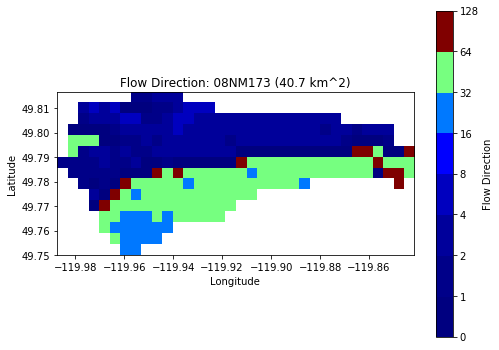

In [178]:
import matplotlib.colors as colors
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='jet')
plt.colorbar(im, ax=ax, boundaries=boundaries, values=sorted(dirmap), label='Flow Direction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Direction: {} ({} km^2)'.format(stn, stn_da))
plt.grid(False)

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0, 0.5, 'Latitude')

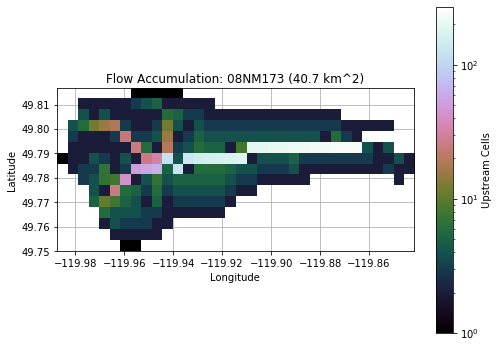

In [179]:

grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation: {} ({} km^2)'.format(stn, stn_da))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Text(0.5, 1.0, 'Flow Distance: 08NM173 (40.7 km^2)')

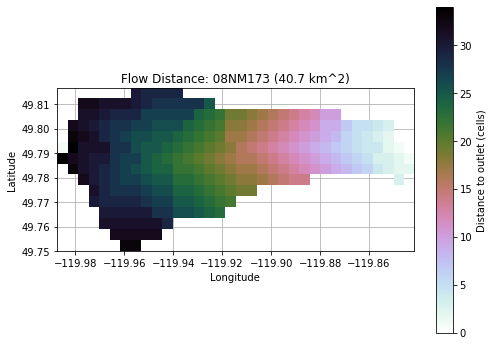

In [180]:

grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)


fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance: {} ({} km^2)'.format(stn, stn_da))

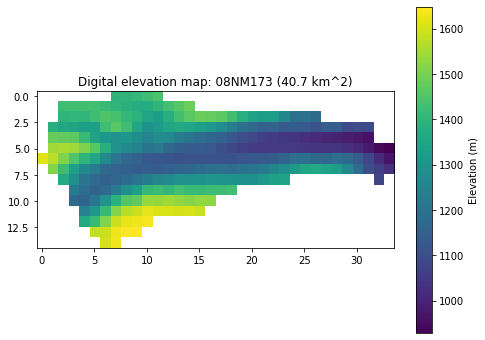

In [181]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

catch = grid.view('dem', nodata=np.nan)
plt.imshow(catch)

# plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map: {} ({} km^2)'.format(stn, stn_da))
plt.grid(False)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.tight_layout()

Text(0, 0.5, 'Latitude')

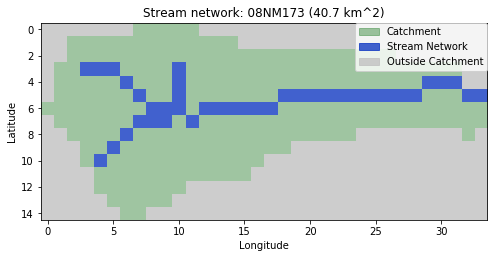

In [182]:

area_threshold=10
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
# plt.grid('on', zorder=0)

streamnetwork_img = np.where(acc_img>area_threshold, 100, 1+acc_img*0)
labels = {1:'Catchment', 2: 'Outside Catchment', 100: 'Stream Network'}
cmap = {1: [0.247, 0.552, 0.266, 0.5], 
        100: [0.074, 0.231, 0.764, 0.8],
       2: [0.760, 0.760, 0.760, 0.8]}

arrayShow = np.array([[cmap[2] if np.isnan(i) else cmap[i] for i in j] for j in streamnetwork_img])    
## create patches as legend

patches =[mp.Patch(color=cmap[i],label=labels[i]) for i in cmap]

#streamnetwork_img = np.where(grid.mask, > 100, 10 , 1)
# im = ax.imshow(streamnetwork_img, extent=grid.extent, zorder=2,
#                 cmap='cubehelix')
im = ax.imshow(arrayShow)
plt.legend(handles=patches, loc=1, borderaxespad=0.)
# plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Stream network: {} ({} km^2)'.format(stn, stn_da))
plt.xlabel('Longitude')
plt.ylabel('Latitude')


/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/pyproj/crs/crs.py:279: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initiali

Text(0.5, 1.0, 'Weighted Flow Distance: 08NM173 (40.7 km^2)')

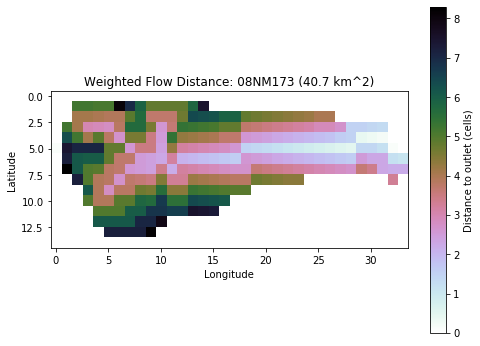

In [190]:
grid = Grid.from_raster(path=FP_DIR + '/na_dem_15s/na_dem_15s', data_name='dem')
grid.read_raster(GDIR_DIR + '/na_dir_15s/na_dir_15s', data_name='dir')
# reset the nodata from -32768 so it doesn't throw off the 

basin_data = get_basin_data(stn)
basin_geom = basin_data.geometry
basin_geom = basin_geom.to_crs(4326)
basin_bounds = basin_geom.bounds
stn_info = wsc_info[wsc_info['Station Number'] == stn]
stn_da = stn_info['DA'].values[0]
x, y = stn_info['Longitude'].values[0], stn_info['Latitude'].values[0]
#     grid.clip_to('catch')
#     grid.resolve_flats('dem', out_name='inflated_dem')
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
           recursionlimit=15000, xytype='label', nodata_out=0)
grid.clip_to('catch')

grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

fig, ax = plt.subplots(figsize=(8,6))

# plt.grid('on', zorder=0)

acc = grid.view('acc')

weights = (np.where(acc, 0.1, 0)
               + np.where((0 < acc) & (acc <= 10), 1, 0)).ravel()
dists = grid.flow_distance(data='catch', x=x, y=y, weights=weights,
                               xytype='label', inplace=False)

plt.imshow(dists,
               cmap='cubehelix_r')

plt.colorbar(im, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Weighted Flow Distance: {} ({} km^2)'.format(stn, stn_da))

